In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

In [2]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix


'jupyter' is not recognized as an internal or external command,
operable program or batch file.
'jupyter' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Install requirements
!python -m pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

## Loading the Dataset

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
# Define transforms
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

# making a validation set 
train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size

train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

valid_loader= DataLoader(valid_data, batch_size= 64, shuffle= False)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform= transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:08<00:00, 1198034.81it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 174181.93it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1201089.72it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2219048.20it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



## Explore the Dataset matplotlib, numpy, and torch

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


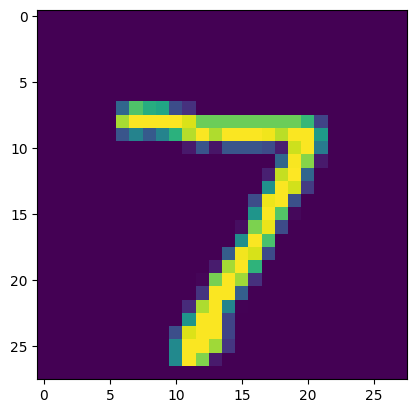

2


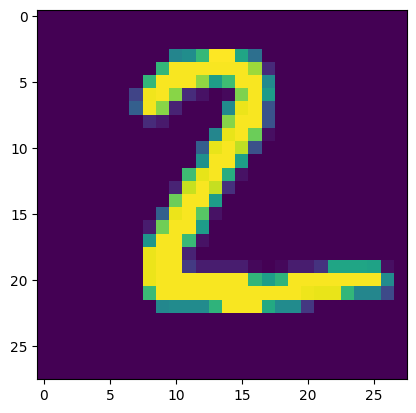

1


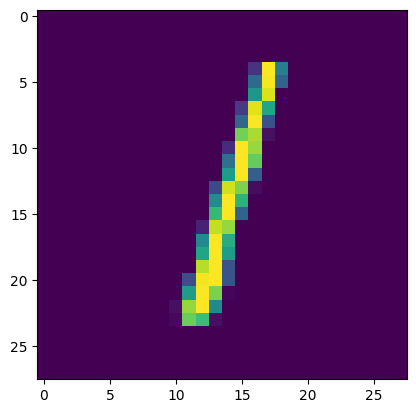

0


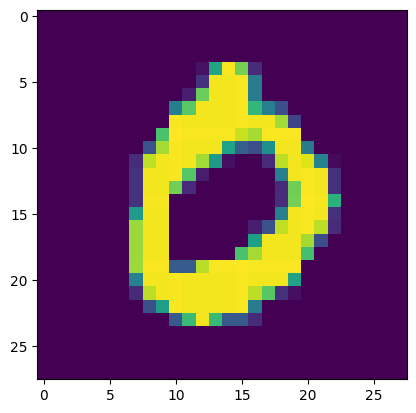

4


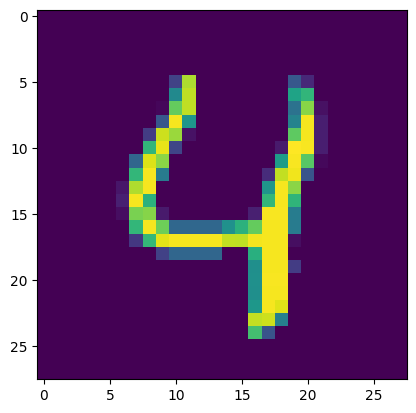

In [8]:
# Explore data
show5(test_loader)

## creating the Neural Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

loss function and an optimizer

In [10]:
optimizer = optim.SGD(net.parameters(), lr = 0.002, momentum=0.9)

criterion = nn.CrossEntropyLoss()

## training the Neural Network

In [11]:
train_losses = [] 
valid_losses = []  
valid_accuracies = [] 
def train_fun(model, train_loader,valid_loader, criterion, optimizer, device, epochs = 20, patience = 5):
    model.to(device)
    model.train()
    best_valid_loss = float('inf')
    no_improvement = 0
    

    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
            
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss +=loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 250 == 0:  
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.6f}, Accuracy: {100 * correct / total:.2f}%')
        
                train_loss = running_loss / len(train_loader)
                train_losses.append(train_loss)
        
        
        valid_loss = 0.0
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
                valid_loss /= len(valid_loader)       
                valid_losses.append(valid_loss)
        
                valid_accuracy = 100 * correct_val / total_val
                valid_accuracies.append(valid_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / len(train_loader):.6f}, Validation Loss: {valid_loss:.6f}, Validation Accuracy: {100 * correct_val / total_val:.2f}%')


        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f'Validation loss has not improved for {patience} consecutive epochs. Early stopping...')
            break

    print('Training finished.')

     
train_fun(net, train_loader,valid_loader, criterion, optimizer, device)

Epoch [1/20], Batch [1/938], Loss: 2.339268, Accuracy: 7.81%
Epoch [1/20], Batch [251/938], Loss: 0.840416, Accuracy: 48.18%
Epoch [1/20], Batch [501/938], Loss: 0.525648, Accuracy: 65.29%
Epoch [1/20], Batch [751/938], Loss: 0.360973, Accuracy: 72.53%
Epoch [1/20], Training Loss: 0.811706, Validation Loss: 0.002346, Validation Accuracy: 89.42%
Epoch [2/20], Batch [1/938], Loss: 0.384282, Accuracy: 90.62%
Epoch [2/20], Batch [251/938], Loss: 0.302407, Accuracy: 89.68%
Epoch [2/20], Batch [501/938], Loss: 0.627984, Accuracy: 90.00%
Epoch [2/20], Batch [751/938], Loss: 0.246204, Accuracy: 90.33%
Epoch [2/20], Training Loss: 0.328873, Validation Loss: 0.001722, Validation Accuracy: 91.83%
Epoch [3/20], Batch [1/938], Loss: 0.279823, Accuracy: 90.62%
Epoch [3/20], Batch [251/938], Loss: 0.178566, Accuracy: 91.55%
Epoch [3/20], Batch [501/938], Loss: 0.292094, Accuracy: 91.69%
Epoch [3/20], Batch [751/938], Loss: 0.136993, Accuracy: 91.97%
Epoch [3/20], Training Loss: 0.271626, Validation L

Plotting the training loss 

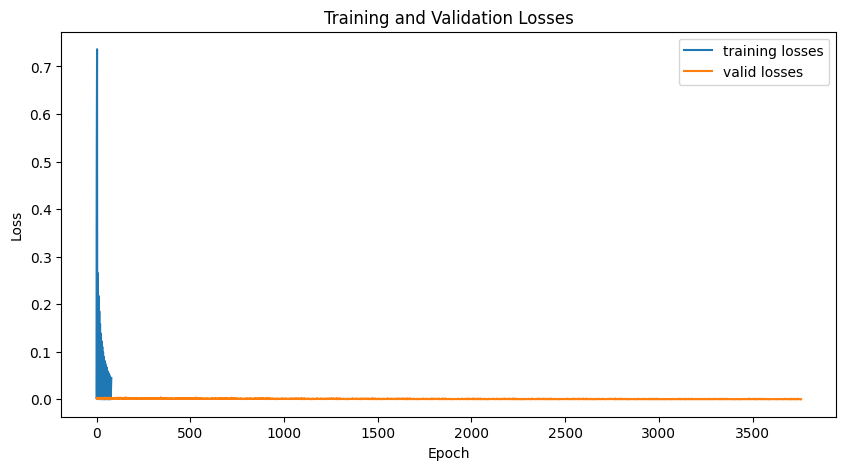

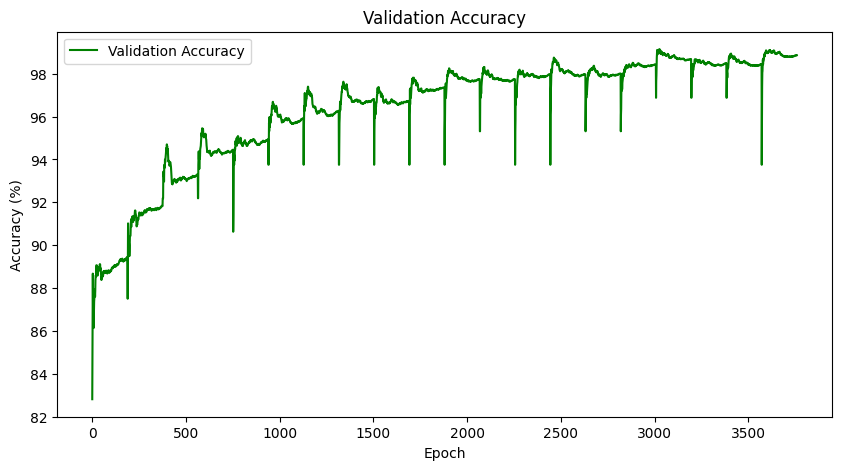

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='training losses')
plt.plot(valid_losses, label='valid losses')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(valid_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Testing model

In [13]:
def test_accuracy(model, test_loader, device):
    model.eval()  
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

test_accuracy(net, test_loader, device)


Test Accuracy: 97.46%


## Saving model

In [15]:
torch.save(net, 'model.pth')